<center><H1><b>DS203: Assignment 7</b></H1></center>
<center><H2>Name : Vinit Awale</H2></center>
<center><H2>Roll No : 18D070067</H2></center>
<center><H3><b>Question 2: XNOR</b></H3></center>

<H2> Imports </H2>

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Data Generation

Firstly generate 10K points in $[1, 1] × [1, 1]$ 

In [2]:
np.random.seed(0)

data = 2*np.random.uniform(size=(10000, 2)) - 1

In [3]:
## Label the data
label = np.zeros(data.shape[0]).reshape(-1, 1)

data = np.concatenate((data, label), axis=1)

## Labeling the data based on quadrant
data[(data[:,0] > 0) & (data[:,1] > 0), 2] = 1        # Quadrant 1
data[(data[:,0] < 0) & (data[:,1] < 0), 2] = 1        # Quadrant 3
## Second and fourth quadrant are already labeled as 0

In [4]:
data

array([[ 0.09762701,  0.43037873,  1.        ],
       [ 0.20552675,  0.08976637,  1.        ],
       [-0.1526904 ,  0.29178823,  0.        ],
       ...,
       [ 0.90710145,  0.49634901,  1.        ],
       [-0.40346677, -0.10708848,  1.        ],
       [-0.27974677,  0.25177329,  0.        ]])

## EXERCISES

### Custom Dataset

In [5]:
## Custom Dataset

class XNORDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx, :2]
        y = self.data[idx, 2]
        
        return (x, y)

In [6]:
dataset = XNORDataset(data)

In [7]:
dataset[0]

(array([0.09762701, 0.43037873]), 1.0)

### Data Loader

In [8]:
## Split the dataset for training, validation and testing

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

## Data Loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

The different parameters of Dataloader are as follows:
- batch_size: Number of samples per batch.
- shuffle: If True, the data will be shuffled.
- drop_last: If True, the last batch will be dropped in case the batch_size does not evenly divide the dataset size.

In [9]:
## Hyperparameters

hidden_size = 4
learning_rate = 1e-3
num_epochs = 20

### Neural Network

In [10]:
# Here we make a neural network with two inputs and a single numeric output
# The network has two linear layers, one with 2 neurons and the other with variable number of neurons (default being 4)

class Neural_Network(nn.Module):
    def __init__(self, hidden_size = 4):
        super(Neural_Network, self).__init__()
        self.linear1 = nn.Linear(2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = torch.sigmoid(x)
        
        return x
    

In [11]:
## Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
## Initialize the model
model = Neural_Network(hidden_size).to(device)

### Loss Function

In [13]:
loss_functions = [nn.LogSoftmax(dim=1), nn.NLLLoss(), nn.CrossEntropyLoss(), nn.MSELoss()]

criterion = loss_functions[2]

### Optimizer

In [14]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### Training and Validation Loop

In [15]:
def train_and_validate(num_epochs, model, print_val_accuracy = False):
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_error = 0
        val_error = 0
        num_correct_train = 0
        num_samples_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Get data to the device
            data = data.to(device = device).float()
            target = target.to(device = device).long()
            
            # Forward
            prediction = model(data).reshape(-1,)
            
            # Convert prediction to probability distribution
            prediction_vector = torch.zeros(prediction.shape[0], 2)
            prediction_vector[:,0] = 1 - prediction
            prediction_vector[:,1] = prediction
            prediction_vector = prediction_vector.to(device = device)
        
            loss = criterion(prediction_vector, target).float()

            # Backward
            optimizer.zero_grad()
            loss.backward() 

            # Update the weights
            optimizer.step()

            # Update the error
            train_error += loss

            # Accuracy
            prediction = (prediction > 0.5).float()
            num_correct_train += (prediction == target).sum()
            num_samples_train += prediction.shape[0]

        train_losses.append(float(train_error/len(train_loader)))
        train_accuracies.append(float(num_correct_train/num_samples_train))

        # Validate the model after every epoch
        num_correct_val = 0
        num_samples_val = 0

        # Set the model to eval mode
        model.eval()

        with torch.no_grad():
            for (x,y) in val_loader:
                x = x.to(device).float()
                y = y.to(device).long()

                # Get the predictions
                pred = model(x).reshape(-1,)

                # Convert the predictions to probability distribution
                pred_vector = torch.zeros(pred.shape[0], 2)
                pred_vector[:,0] = 1 - pred
                pred_vector[:,1] = pred
                pred_vector = pred_vector.to(device = device)

                # Calculate the loss
                loss = criterion(pred_vector, y).float()

                # Change the prediction scores to labels
                pred = (pred>0.5).float()

                num_correct_val += (pred == y).sum()
                num_samples_val += pred.size(0)


                # Update the validation error
                val_error += loss

        val_losses.append(float(val_error/len(val_loader)))
        val_accuracy = num_correct_val/num_samples_val

        val_accuracies.append(float(val_accuracy))
        model.train()

        if print_val_accuracy:
            print("Epoch :", str(epoch), "Validation Accuracy :", str(round(float(val_accuracy),3)))

    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies =  train_and_validate(num_epochs = 100, model = model, print_val_accuracy= True)

Epoch : 0 Validation Accuracy : 0.525
Epoch : 1 Validation Accuracy : 0.54
Epoch : 2 Validation Accuracy : 0.548
Epoch : 3 Validation Accuracy : 0.554
Epoch : 4 Validation Accuracy : 0.561
Epoch : 5 Validation Accuracy : 0.566
Epoch : 6 Validation Accuracy : 0.574
Epoch : 7 Validation Accuracy : 0.581
Epoch : 8 Validation Accuracy : 0.592
Epoch : 9 Validation Accuracy : 0.599
Epoch : 10 Validation Accuracy : 0.608
Epoch : 11 Validation Accuracy : 0.613
Epoch : 12 Validation Accuracy : 0.619
Epoch : 13 Validation Accuracy : 0.626
Epoch : 14 Validation Accuracy : 0.631
Epoch : 15 Validation Accuracy : 0.63
Epoch : 16 Validation Accuracy : 0.633
Epoch : 17 Validation Accuracy : 0.636
Epoch : 18 Validation Accuracy : 0.632
Epoch : 19 Validation Accuracy : 0.63
Epoch : 20 Validation Accuracy : 0.631
Epoch : 21 Validation Accuracy : 0.63
Epoch : 22 Validation Accuracy : 0.627
Epoch : 23 Validation Accuracy : 0.628
Epoch : 24 Validation Accuracy : 0.628
Epoch : 25 Validation Accuracy : 0.628


### Plots

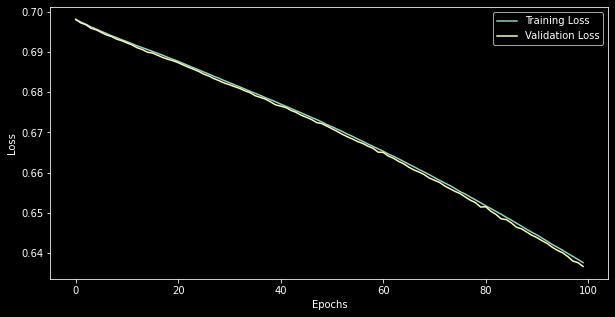

In [17]:
## Trainin and Validation Losses vs Epochs

plt.figure(figsize=(10,5))
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

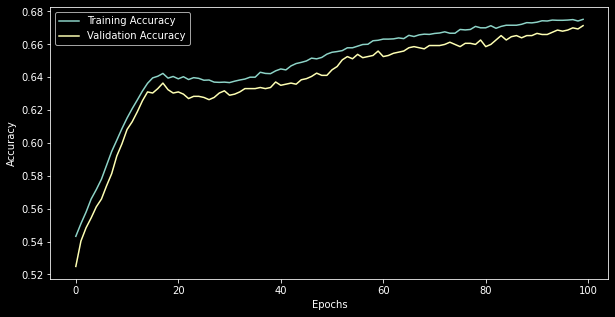

In [18]:
## Training and Validation accuracy vs epoch in a single plot

plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label = "Training Accuracy")
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
## Best Validation loss vs Hidden Layer size (use hidden size to be (2,4,6,8,10))

model_2 = Neural_Network(2).to(device)
train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2 =  train_and_validate(num_epochs = 20, model = model_2, print_val_accuracy= False)

model_4 = Neural_Network(4).to(device)
train_losses_4, val_losses_4, train_accuracies_4, val_accuracies_4 =  train_and_validate(num_epochs = 20, model = model_4, print_val_accuracy= False)

model_6 = Neural_Network(6).to(device)
train_losses_6, val_losses_6, train_accuracies_6, val_accuracies_6 =  train_and_validate(num_epochs = 20, model = model_6, print_val_accuracy= False)

model_8 = Neural_Network(8).to(device)
train_losses_8, val_losses_8, train_accuracies_8, val_accuracies_8 =  train_and_validate(num_epochs = 20, model = model_8, print_val_accuracy= False)

model_10 = Neural_Network(10).to(device)
train_losses_10, val_losses_10, train_accuracies_10, val_accuracies_10 =  train_and_validate(num_epochs = 20, model = model_10, print_val_accuracy= False)


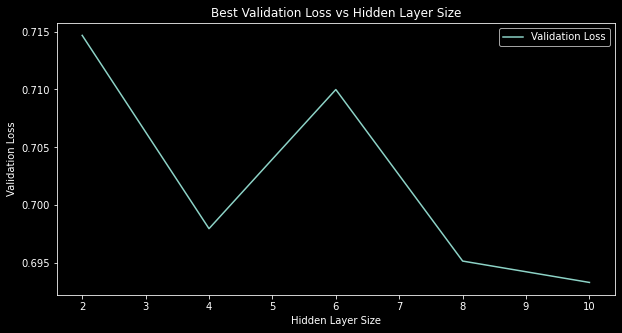

In [20]:
val_losses = [np.min(val_losses_2), np.min(val_losses_4), np.min(val_losses_6), np.min(val_losses_8), np.min(val_losses_10)]

hidden_layer_size = [2,4,6,8,10]

plt.figure(figsize=(10,5))
plt.plot(hidden_layer_size, val_losses, label = "Validation Loss")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Validation Loss")
plt.title("Best Validation Loss vs Hidden Layer Size")
plt.legend()
plt.show()

In [21]:
### Best Validation loss vs learning rate used (use learning rates in (1e-5,1e-4,1e-3,1e-2,1e-1)) for max number of 20 epochs
# For this part I will be using 10 Hidden Layers since it is the best for the validation loss from the above plot

learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
validation_losses = []

for i in range(len(learning_rates)):
    model_lr = Neural_Network(10).to(device)
    optimizer = optim.SGD(model_lr.parameters(), lr = learning_rates[i])

    train_losses_lr, val_losses_lr, train_accuracies_lr, val_accuracies_lr =  train_and_validate(num_epochs = 20, model = model_lr, print_val_accuracy= False)

    validation_losses.append(np.min(val_losses_lr))


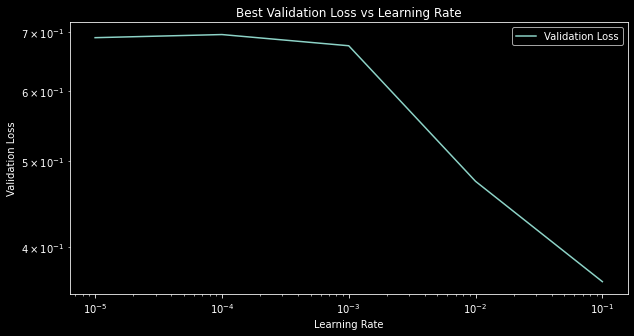

In [22]:
## Plot best validation loss vs learning rate

plt.figure(figsize=(10,5))
# Make log plot of learning rate vs validation loss
plt.loglog(learning_rates, validation_losses, label = "Validation Loss")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
plt.title("Best Validation Loss vs Learning Rate")
plt.legend()
plt.show()

From the above plots we can see that we get best validation loss for 10 Hidden Layers and learning rate of 1e-1. Now let us test the model with best hyperparameters on the test set.

In [23]:
### Results on test set

best_model = Neural_Network(10).to(device)
optimizer = optim.SGD(best_model.parameters(), lr = 1e-1)

num_epochs = 100
# Training the best_model
for epoch in range(num_epochs):     
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get data to the device
        data = data.to(device = device).float()
        target = target.to(device = device).long()
        
        # Forward
        prediction = best_model(data).reshape(-1,)
        
        # Convert prediction to probability distribution
        prediction_vector = torch.zeros(prediction.shape[0], 2)
        prediction_vector[:,0] = 1 - prediction
        prediction_vector[:,1] = prediction
        prediction_vector = prediction_vector.to(device = device)
    
        loss = criterion(prediction_vector, target).float()

        # Backward
        optimizer.zero_grad()
        loss.backward() 

        # Update the weights
        optimizer.step()


In [24]:
## Plot the results on test set

test_data = []
test_predictions = []

for batch_idx, (data, target) in enumerate(test_loader):
    # Get data to the device
    data = data.to(device = device).float()
    target = target.to(device = device).long()
    
    # Forward
    prediction = best_model(data).reshape(-1,)
    
    prediction = (prediction > 0.5).float()

    test_data.append(data.cpu().detach().numpy())
    test_predictions.append(prediction.cpu().detach().numpy())


In [25]:
test_data = np.array(test_data)
test_predictions = np.array(test_predictions)

test_data = test_data.reshape(-1,2)
test_predictions = test_predictions.reshape(-1,1)

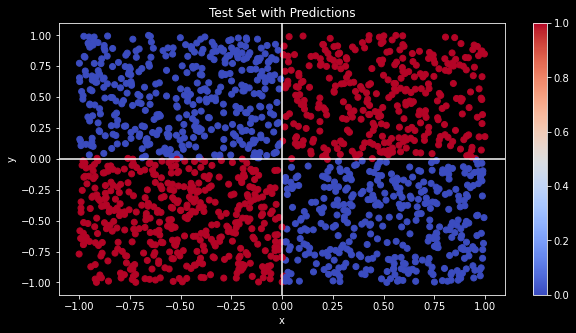

In [26]:
# Plot the results on test set with the predictions with x for 1 and o for 0 predictions

plt.figure(figsize=(10,5))
plt.scatter(test_data[:,0], test_data[:,1], c = test_predictions, cmap = "coolwarm")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test Set with Predictions")
plt.axvline(x=0)
plt.axhline(y=0)
plt.colorbar()
plt.show()

The results obtained here are very good. I have not calculated the test accuracy as it has been already calculated earlier while determining the best hyperparameters. However, from the above plot we can easily see that the model is able to classify the test data correctly.